#### Необходимые импорты и подключения

In [1]:
from qiskit import * 
from qiskit.tools.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
import numpy as np

IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')

#### Вспомогательная функция установки нужного базисного состояния

In [2]:
def set_basis_state(circuit, vector_values):
    for i in range(len(vector_values)):
        if (vector_values[i] == 1):
            circuit.x(i)

## Исходный метод

*Основные функции:*

In [3]:
def create_clear_circuit_original(n):
    return QuantumCircuit(n, n)

def construct_SCS_std(circuit, k):
    circuit.cx(k-2, k-1)
    circuit.cry(2*np.arccos(np.sqrt(1/k)),
                circuit.qubits[k-1], 
                circuit.qubits[k-2])
    circuit.cx(k-2, k-1)
    for i in range(2, k):
        circuit.cx(k-i-1, k-1)
        circuit.mcry(2*np.arccos(np.sqrt(i/k)),
                     [circuit.qubits[k-1], circuit.qubits[k-i]],
                     circuit.qubits[k-i-1],
                     [])
        circuit.cx(k-i-1, k-1)

def construct_U(circuit, n):
    for i in range(n, 1, -1):
        construct_SCS_std(circuit, i)

*Интерфейс:*

In [4]:
def get_original_circuit(circuit, n, test=[]):
    set_basis_state(circuit, test)
    construct_U(circuit, n)
    for i in range(n):
        circuit.measure(i, i)

*Пример тестирования на симуляторе, генерация $|D_{3}^{5}\rangle $:*  

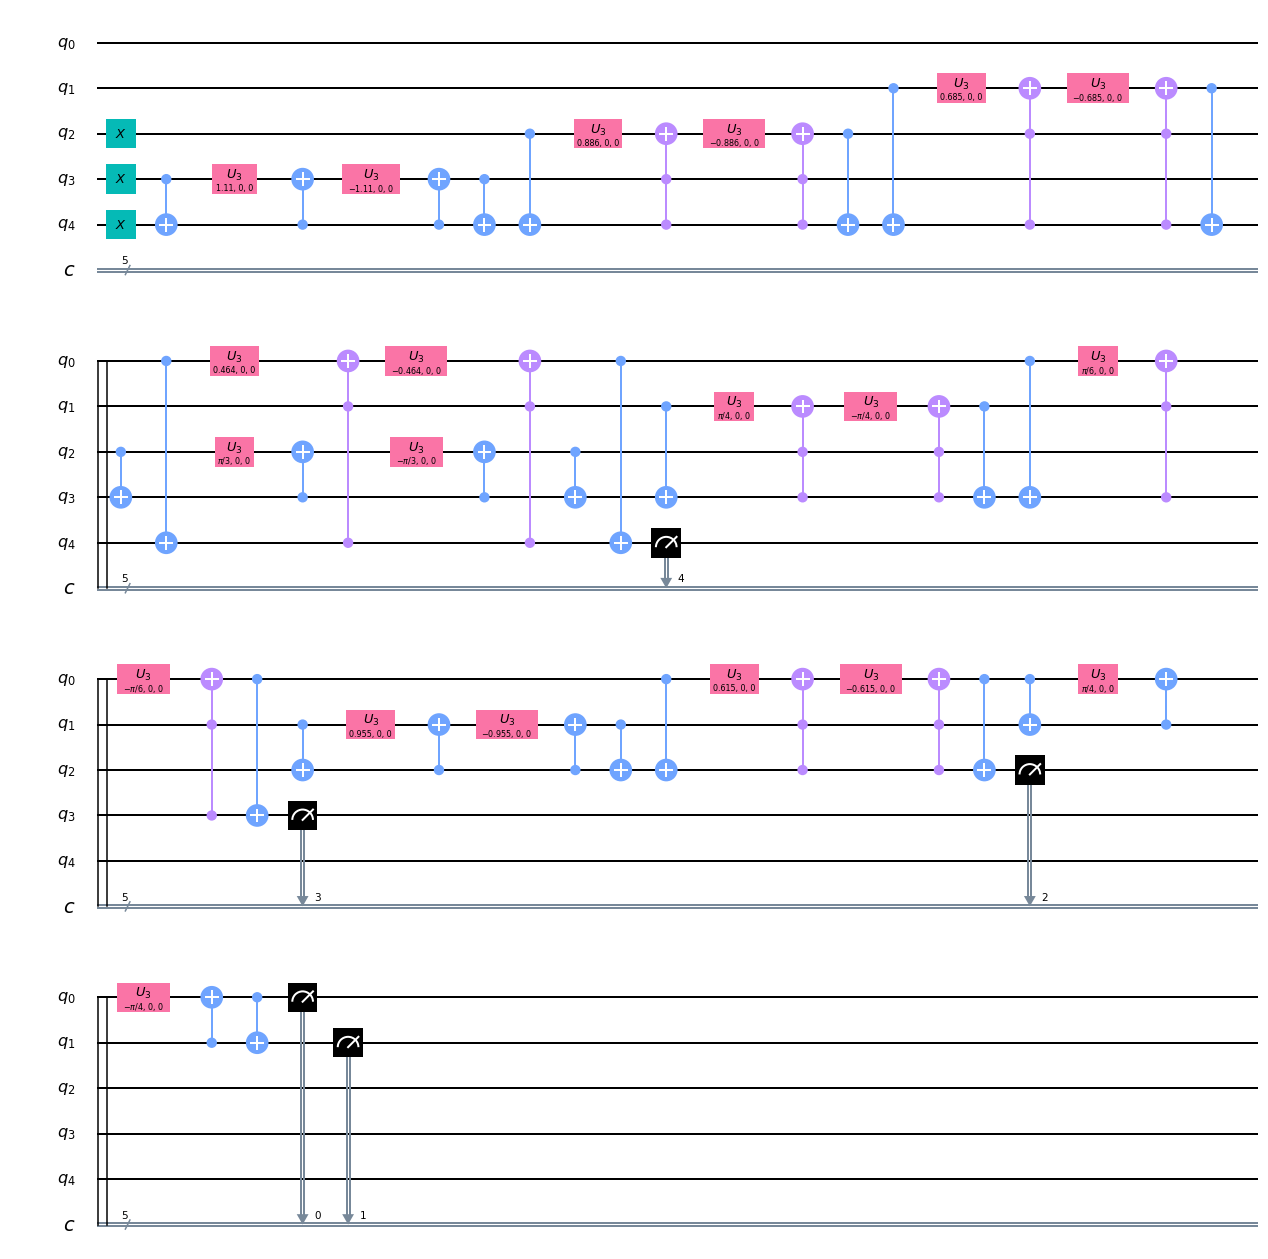

In [5]:
# Построение схемы
circuit = create_clear_circuit_original(5)
get_original_circuit(circuit, 5, [0, 0, 1, 1, 1])
circuit.draw(output='mpl')

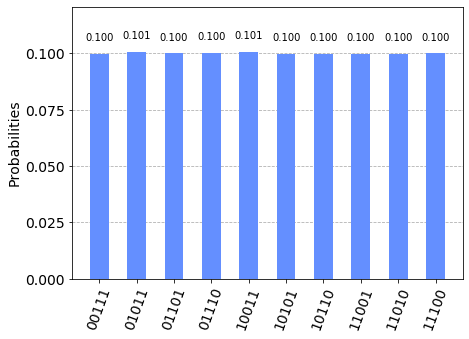

In [6]:
# Запуск на симуляторе
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots=1000000).result()
plot_histogram(result.get_counts(circuit))

*Пример тестирования на квантовом процессоре (+симулятор), генерация $ |D_{1}^{3} \rangle $ на ibmq_vigo:*

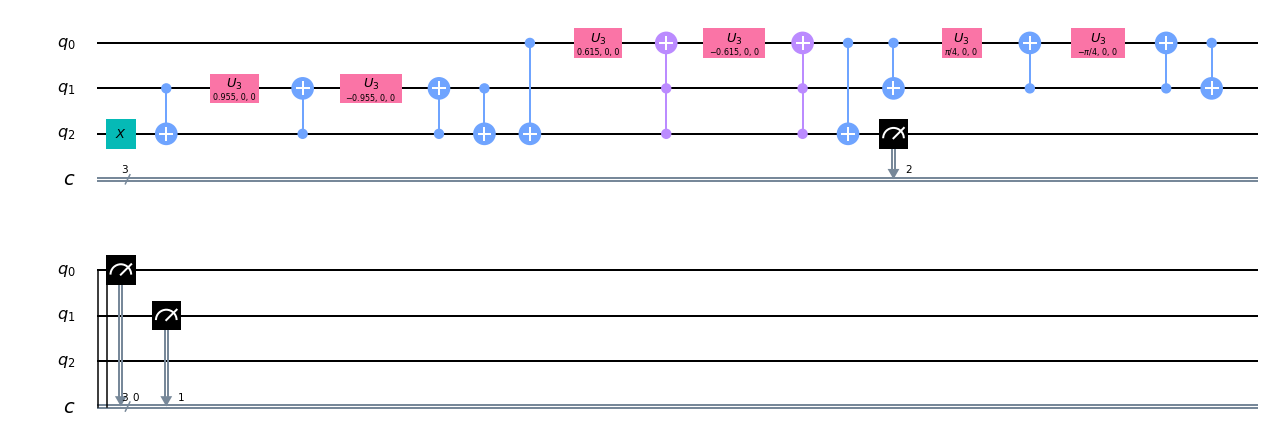

In [7]:
# Построение схемы
circuit = create_clear_circuit_original(3)
get_original_circuit(circuit, 3, [0, 0, 1])
circuit.draw(output='mpl')

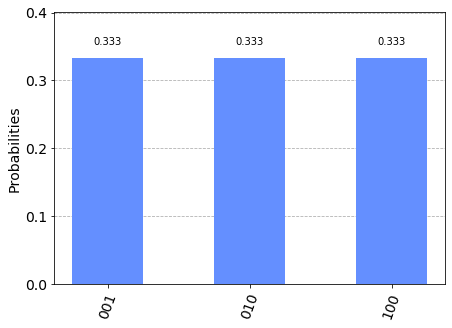

In [8]:
# Запуск на симуляторе
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots=1000000).result()
plot_histogram(result.get_counts(circuit))

Job Status: job has successfully run


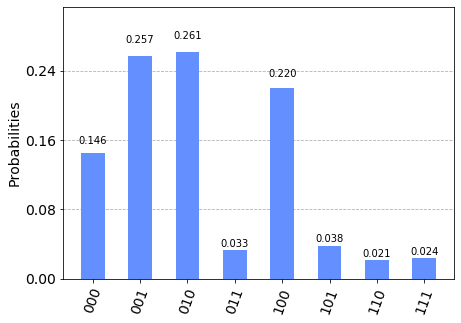

In [9]:
# Запуск на ibmq_vigo
qcomp = provider.get_backend('ibmq_vigo')
job = execute(circuit, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(circuit))

## «Квантовый» метод

*Основные функции:*

In [17]:
def get_N(n):
    return 2*n - 3
            
def construct_P(circuit, ind, k):
    if (k == 2):
        circuit.cx(ind, ind-1)
        circuit.cx(ind-1, ind)
        return
    circuit.cx(ind, ind - k + 1)
    for i in range(ind - k + 2, ind):
        circuit.x(i)    
    circuit.barrier()
    q_controls = []
    for i in range(k - 1):
            q_controls.append(circuit.qubits[ind-k+1+i])
    if (k<4):
        circuit.ccx(q_controls[0], q_controls[1], circuit.qubits[ind])
    else:
        q_ancilla = []
        for i in range(k - 3):
            q_ancilla.append(circuit.qubits[ind+1+i])
        circuit.mct(q_controls, circuit.qubits[ind], q_ancilla, mode='basic')
    circuit.barrier()
    for i in range(ind - k + 2, ind):
        circuit.x(i)
        

def construct_SCS_ctrl(circuit, k, ancilla_ind, ind):
    circuit.cx(k-2, k-1)
    circuit.mcry(2*np.arccos(np.sqrt(1/k)), [circuit.qubits[k-1], circuit.qubits[ind]] , circuit.qubits[k-2], [])
    circuit.cx(k-2, k-1)
    for i in range(2, k):
        circuit.cx(k-i-1, k-1)
        circuit.mcry(2*np.arccos(np.sqrt(i/k)), 
                     [circuit.qubits[k-1], circuit.qubits[k-i], circuit.qubits[ind]], circuit.qubits[k-i-1],
                     [circuit.qubits[ancilla_ind]])
        circuit.cx(k-i-1, k-1)
        
def construct_Q(circuit, n):
    for i in range(3, n+1):
        construct_P(circuit, n, n-i+2)
        for j in range(i, 1, -1):
            construct_SCS_ctrl(circuit, j, n+1, n)

*Интерфейс:*

In [18]:
def create_clear_circuit_m1(n,  measure='all'):
    if (measure == 'all'):
        return QuantumCircuit(get_N(n), get_N(n)) 
    return QuantumCircuit(get_N(n), measure) 

def get_universal_circuit_m1(circuit, n, measure='all', test=[]):
    set_basis_state(circuit, test)
    construct_Q(circuit, n)
    if (measure == 'all'):
        for i in range(len(circuit.qubits)):
            circuit.measure(i, i)       
    if (measure == 'test_len'):
        for i in range(len(test)):
            circuit.measure(i, i)
    else:
        for i in range(measure):
            circuit.measure(i, i)

*Пример тестирования на симуляторе, генерация $|D_{5}^{6}\rangle $ генератором с $ n = 8 $ :*  

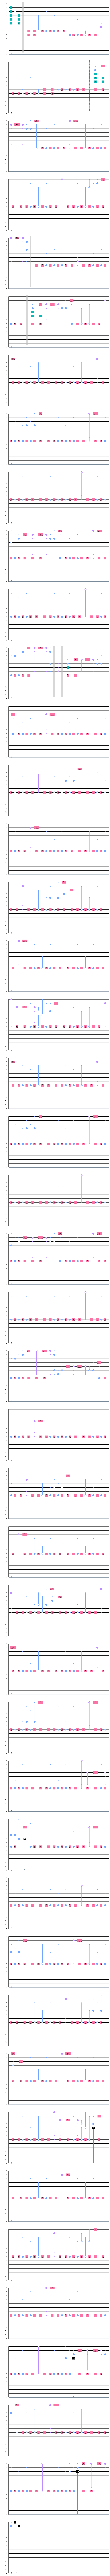

In [19]:
# Построение схемы
circuit = create_clear_circuit_m1(8, measure=6)
get_universal_circuit_m1(circuit, 6, measure='test_len', test=[0, 1, 1, 1, 1, 1])
circuit.draw(output='mpl')

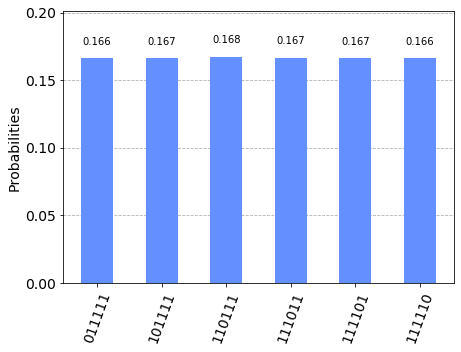

In [20]:
# Запуск на симуляторе
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots=1000000).result()
plot_histogram(result.get_counts(circuit))

*Пример тестирования на квантовом процессоре (+симулятор), генерация $ |D_{1}^{3}\rangle $ генератором с $ n = 4  $ на ibmq_vigo:*

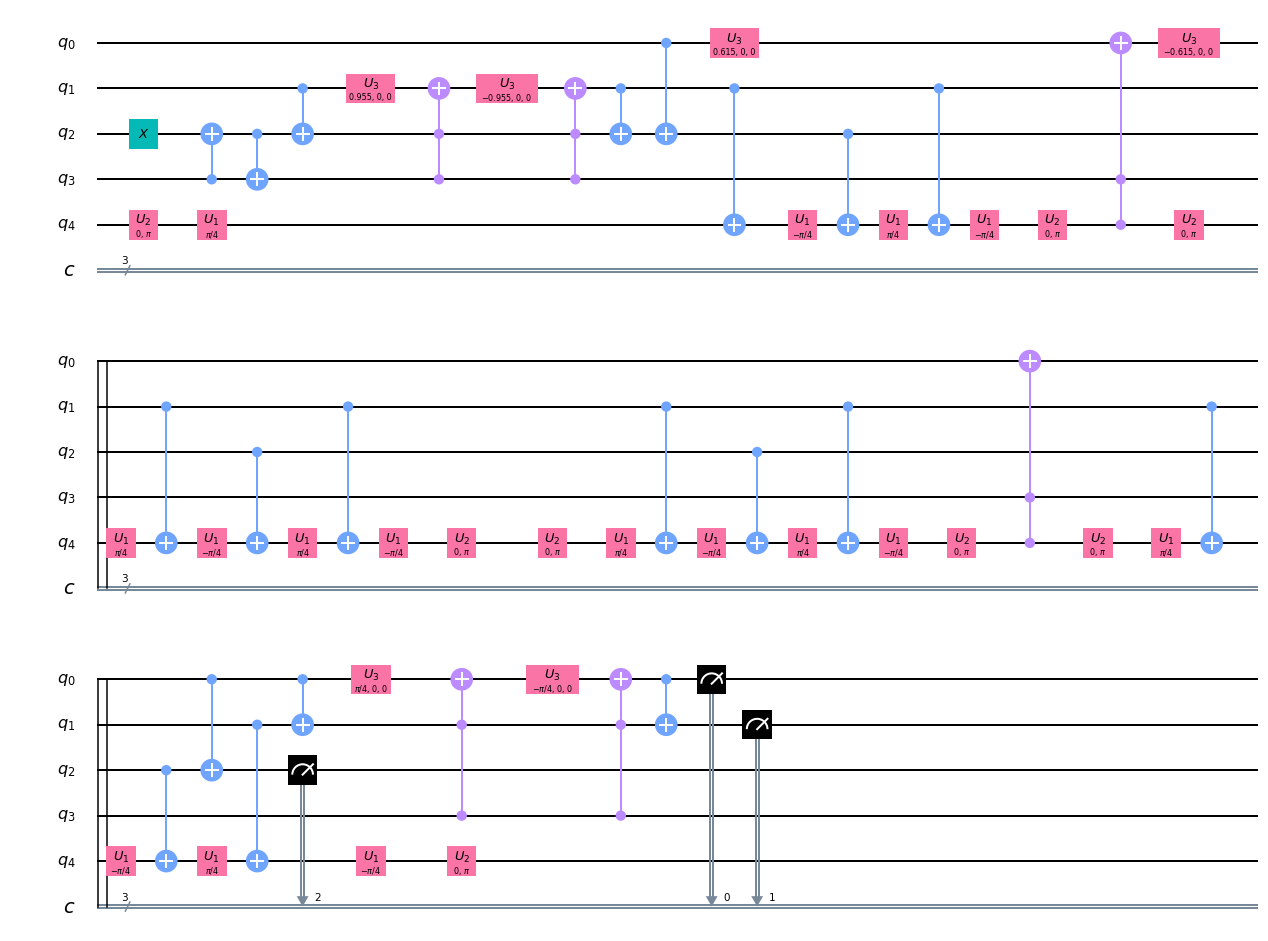

In [21]:
# Построение схемы
circuit = create_clear_circuit_m1(4, measure=3)
get_universal_circuit_m1(circuit, 3, measure='test_len', test=[0, 0, 1])
circuit.draw(output='mpl')

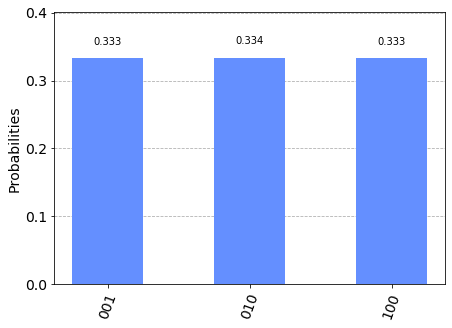

In [22]:
# Запуск на симуляторе
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots=1000000).result()
plot_histogram(result.get_counts(circuit))

Job Status: job has successfully run


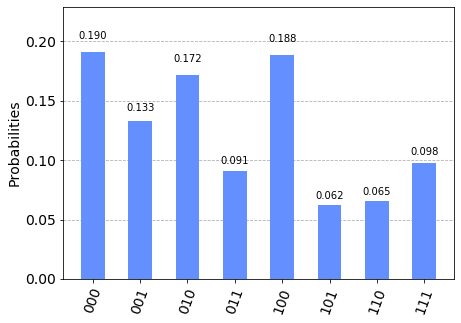

In [23]:
# Запуск на ibmq_vigo
qcomp = provider.get_backend('ibmq_vigo')
job = execute(circuit, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(circuit))

## «Битовый» метод

*Основные функции:*

In [24]:
def construct_SCS_bit(circuit, k, ind, ancilla_ind):
    circuit.cx(k-2, k-1)
    circuit.mcry(2*np.arccos(np.sqrt(1/k)), [circuit.qubits[k-1], circuit.qubits[ind]], circuit.qubits[k-2], [])
    circuit.cx(k-2, k-1)
    for i in range(2, k):
        circuit.cx(k-i-1, k-1)
        circuit.mcry(2*np.arccos(np.sqrt(i/k)), 
                     [circuit.qubits[k-1], circuit.qubits[k-i], circuit.qubits[ind]],
                     circuit.qubits[k-i-1],
                     [circuit.qubits[ancilla_ind]])
        circuit.cx(k-i-1, k-1)

def construct_B(circuit, n):
    for i in range(n, 1, -1):
        construct_SCS_bit(circuit, i, i+n-2, 2*n-1)

*Интерфейс:*

In [25]:
def create_clear_circuit_m2(n, measure=-1):
    if (measure == -1):
        measure = n
    return QuantumCircuit(2*n, measure)  

def get_universal_circuit_m2(circuit, n, test=[]):
    set_basis_state(circuit, test)
    construct_B(circuit, n)
    for i in range(len(circuit.clbits)):
            circuit.measure(i, i)

*Пример тестирования на симуляторе, генерация $|D_{2}^{4}\rangle $ генератором с $ n = 6 $:* 

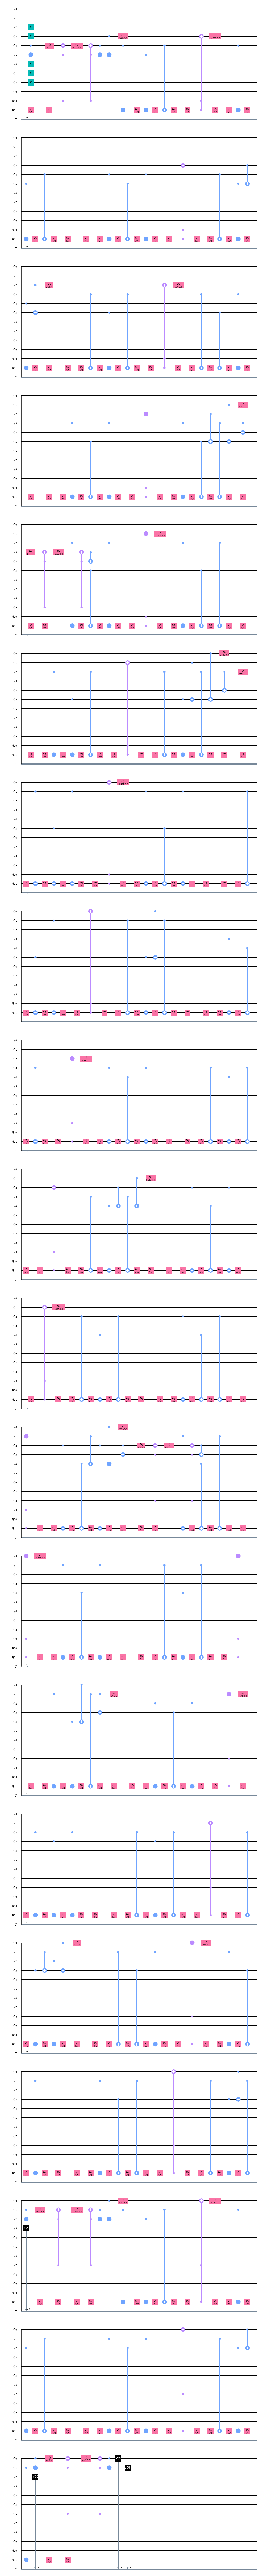

In [26]:
# Построение схемы
circuit = create_clear_circuit_m2(6, measure=4)
get_universal_circuit_m2(circuit, 6, test=[0, 0, 1, 1, 0, 0, 1, 1, 1])
circuit.draw(output='mpl')

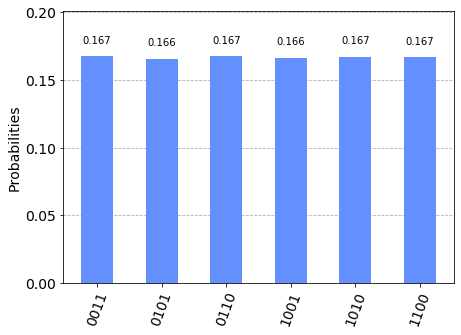

In [27]:
# Запуск на симуляторе
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots=1000000).result()
plot_histogram(result.get_counts(circuit))

*Пример тестирования на квантовом процессоре (+симулятор), генерация $ |D_{1}^{3}\rangle $ генератором с $ n = 4  $ на ibmq_16_melbourne:*

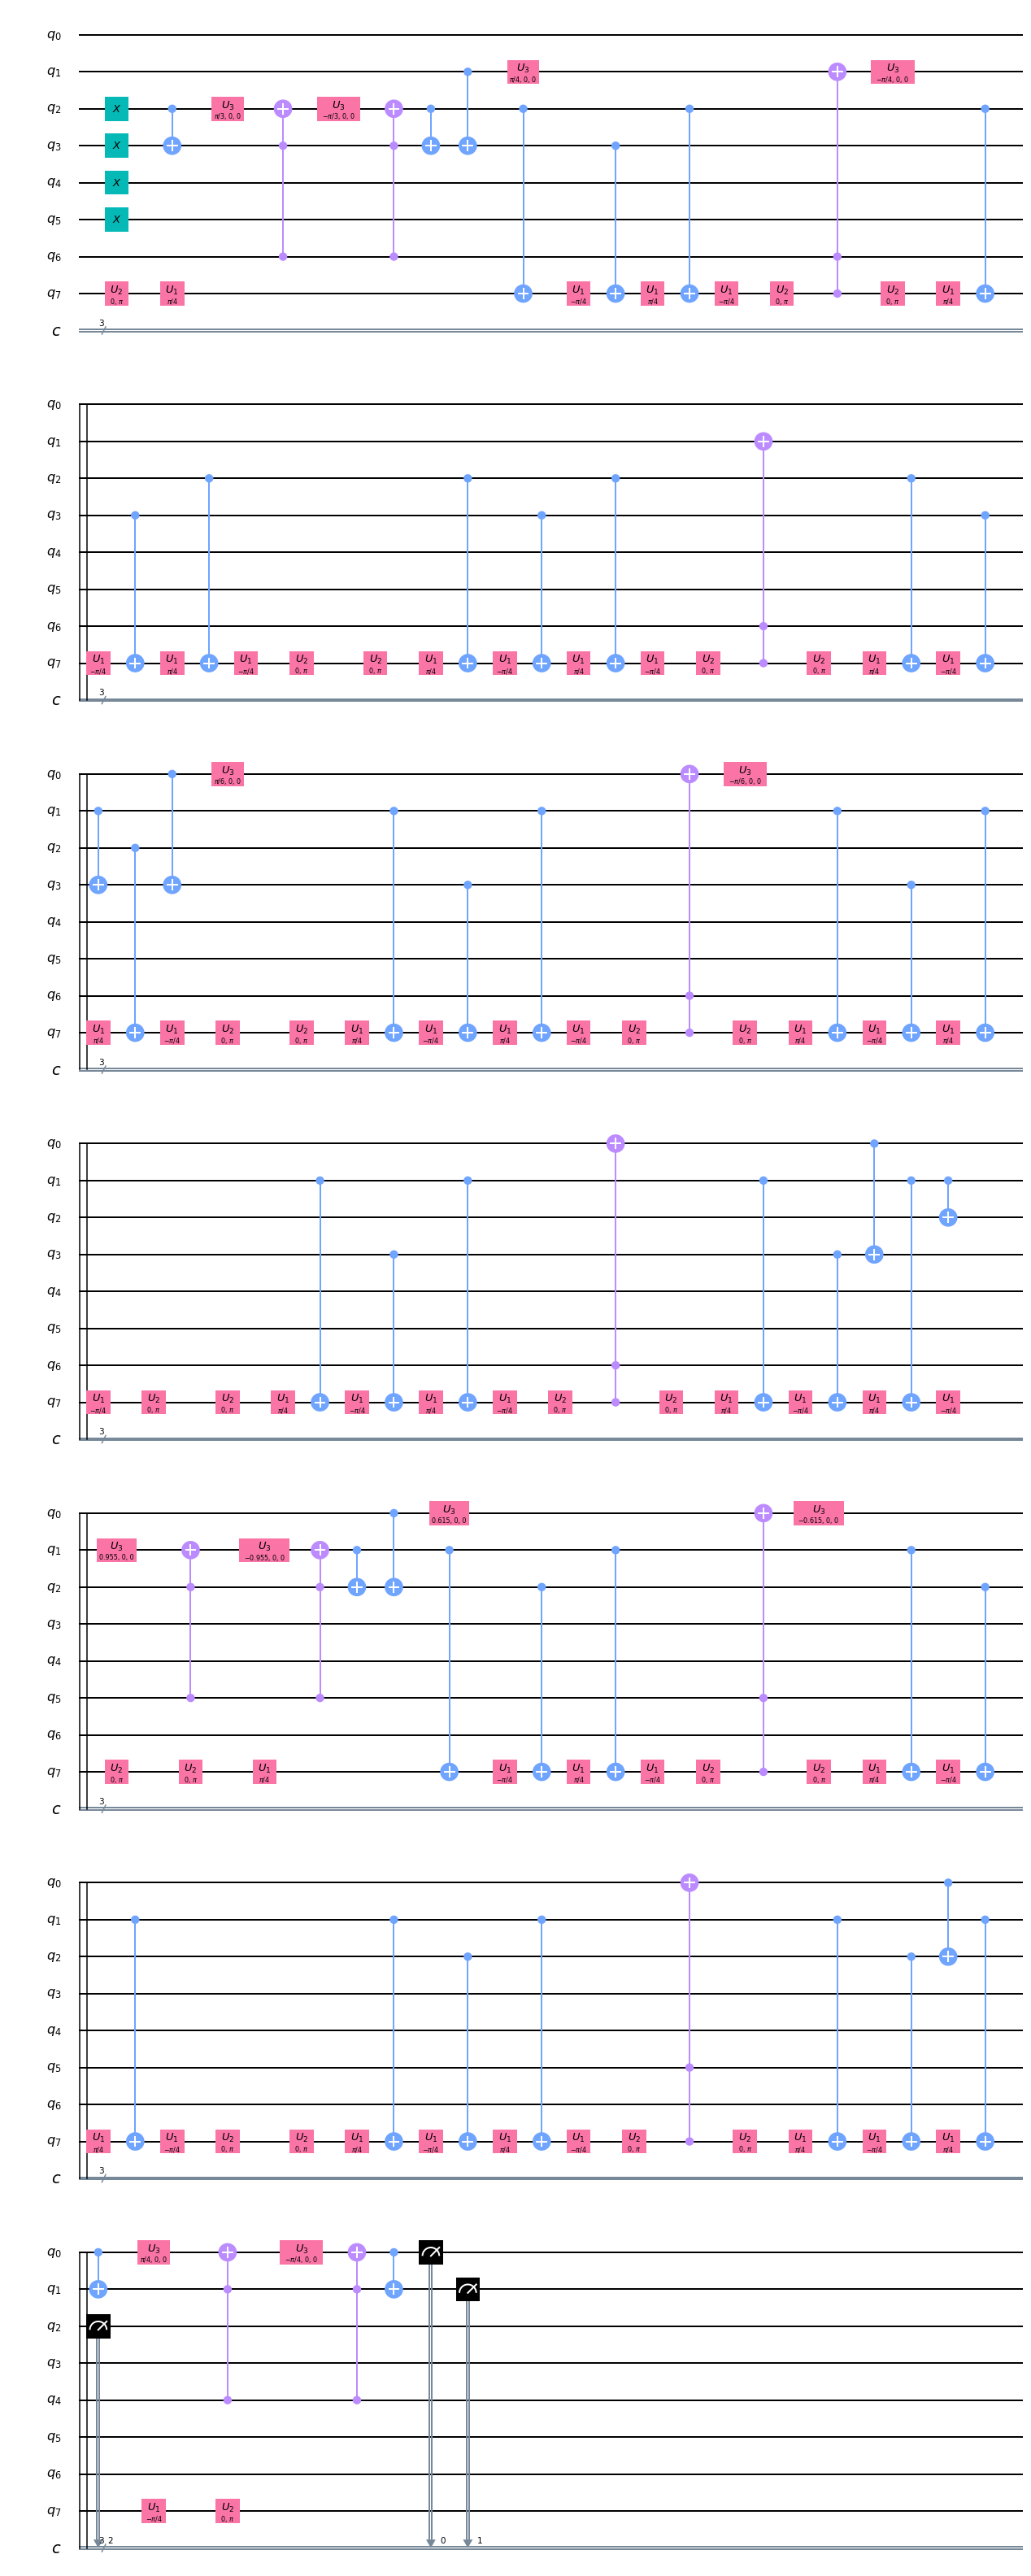

In [31]:
# Построение схемы
circuit = create_clear_circuit_m2(4, measure=3)
get_universal_circuit_m2(circuit, 4, test=[0, 0, 1, 1, 1, 1])
circuit.draw(output='mpl')

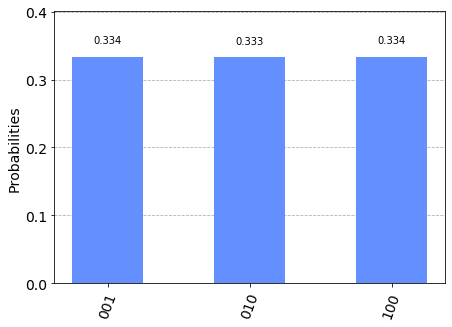

In [32]:
# Запуск на симуляторе
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots=1000000).result()
plot_histogram(result.get_counts(circuit))

Job Status: job has successfully run


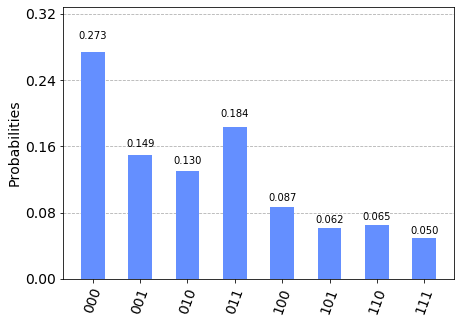

In [33]:
# Запуск на ibmq_16_melbourne
qcomp = provider.get_backend('ibmq_16_melbourne')
job = execute(circuit, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(circuit))